In [1]:
import sys
import os
base_dir = os.path.abspath(".")
sys.path.append(base_dir)

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from models.CtRNet import CtRNet
from models.heatmap import heatmap_to_keypoints



# Panda dataset

In [2]:
import argparse
import imageloaders.panda_step_dataset as psd
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.data_folder = "/home/jingpei/Desktop/CtRNet-robot-pose-estimation/panda_partial_dataset"
args.base_dir = "/home/jingpei/Desktop/CtRNet-robot-pose-estimation"
args.use_gpu = True
args.trained_on_multi_gpus = True
args.keypoint_seg_model_path = os.path.join(args.base_dir,"outputs_server/panda_full_view/net_epoch_280.pth")

args.urdf_file = os.path.join(args.base_dir,"urdfs/Panda/panda.urdf")
args.robot_name = "Panda"
args.n_kp = 12
args.scale = 0.5
args.height = 480
args.width = 640
args.fx, args.fy, args.px, args.py = 302.2686576843262, 302.2694778442383, 320.1951599121094, 241.30935668945312

# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

In [3]:
CtRNet = CtRNet(args)

Loading keypoint segmentation model from /home/jingpei/Desktop/CtRNet-robot-pose-estimation/outputs_server/panda_full_view/net_epoch_280.pth
Camera intrinsics: [[151.13432884   0.         160.09757996]
 [  0.         151.13473892 120.65467834]
 [  0.           0.           1.        ]]
Robot model: Panda


In [17]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



dataset = psd.PandaStepDataset(root_dir=args.data_folder, ep_num=6, scale = args.scale, trans_to_tensor = trans_to_tensor)


In [18]:
points_2d_batch = []
points_3d_batch = []
confidence_batch = []
for i in range(len(dataset)):
    img, joint_angles = dataset.__getitem__(i) 
    if args.use_gpu:
        img = img.cuda()


    points_2d, points_3d, confidence = CtRNet.inference_keypoints_dark(img, joint_angles.cpu().squeeze())
    # concate points to batch
    
    points_2d_batch.append(points_2d.squeeze())
    points_3d_batch.append(points_3d.squeeze())
    confidence_batch.append(confidence.squeeze())

# conver to tensor
points_2d_batch = torch.stack(points_2d_batch)
points_3d_batch = torch.stack(points_3d_batch)
confidence_batch = torch.stack(confidence_batch)

In [19]:
points_2d_batch.shape

torch.Size([344, 12, 2])

In [26]:
filtered_points_2d = []
filtered_points_3d = []
confidence_threshold = 0.6
for i in range(len(points_2d_batch)):
    for j in range(len(points_2d_batch[i])):
        if confidence_batch[i][j] > confidence_threshold:
            filtered_points_2d.append(points_2d_batch[i][j])
            filtered_points_3d.append(points_3d_batch[i][j])
filtered_points_2d = torch.stack(filtered_points_2d)
filtered_points_3d = torch.stack(filtered_points_3d)

In [27]:
cTr_batch = CtRNet.bpnp(filtered_points_2d.unsqueeze(0), filtered_points_3d, CtRNet.K)
cTr_batch

tensor([[ 0.3600,  2.7503, -1.3080,  0.2295,  0.0121,  0.8560]],
       device='cuda:0')

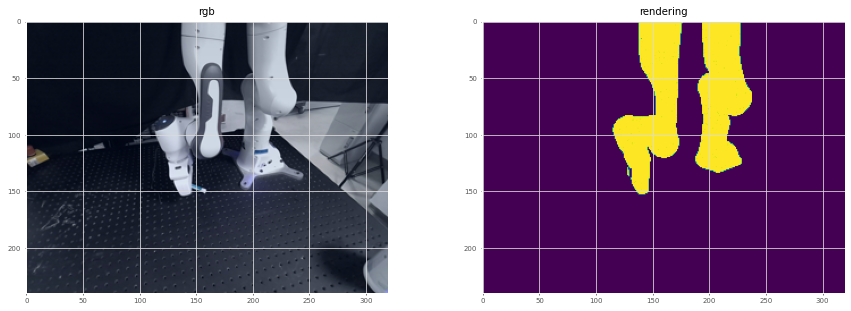

In [28]:
img, joint_angles = dataset.__getitem__(100) 
mesh_files = [base_dir + "/urdfs/Panda/meshes/visual/link0/link0.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link1/link1.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link2/link2.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link3/link3.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link4/link4.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link5/link5.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link6/link6.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link7/link7.obj",
              base_dir + "/urdfs/Panda/meshes/visual/hand/hand.obj",
             ]

robot_renderer = CtRNet.setup_robot_renderer(mesh_files)
robot_mesh = robot_renderer.get_robot_mesh(joint_angles)
rendered_image = CtRNet.render_single_robot_mask(cTr_batch.squeeze(), robot_mesh, robot_renderer)
img_np = to_numpy_img(img)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("rgb")
plt.imshow(img_np)
plt.subplot(1,2,2)
plt.title("rendering")
plt.imshow(rendered_image.squeeze().detach().cpu().numpy())
plt.show()

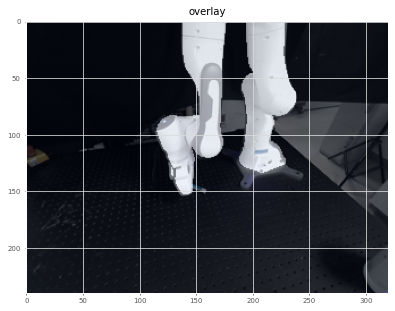

In [29]:
overlay = img_np * 0.5 + np.repeat(rendered_image.squeeze().unsqueeze(2).detach().cpu().numpy() * 0.5, 3, axis=2)

plt.figure(figsize=(15,5))
plt.title("overlay")
plt.imshow(overlay)
plt.show()


In [42]:
img, joint_angles = dataset.__getitem__(80) 

if args.use_gpu:
    img = img.cuda()

cTr, points_2d, segmentation, heatmap = CtRNet.inference_single_image(img, joint_angles.cpu().squeeze(), part="ee", use_dark=True)
print(CtRNet.cTr_to_pose_matrix(cTr))


tensor([[[-0.6003, -0.7986, -0.0420,  0.4459],
         [-0.0302,  0.0751, -0.9967,  0.4876],
         [ 0.7992, -0.5971, -0.0693,  0.3575],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0')


/home/jingpei/Desktop/CtRNet-robot-pose-estimation/models/process_heatmap.py:262: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_indices = torch.cat((max_indices % W, max_indices // W), dim=2).type(heatmap.dtype)


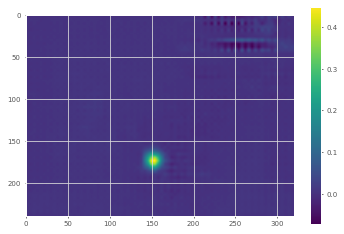

In [43]:
plt.imshow(heatmap.squeeze()[8].detach().cpu().numpy())
plt.colorbar()

In [44]:
mesh_files = [base_dir + "/urdfs/Panda/meshes/visual/link0/link0.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link1/link1.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link2/link2.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link3/link3.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link4/link4.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link5/link5.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link6/link6.obj",
              base_dir + "/urdfs/Panda/meshes/visual/link7/link7.obj",
              base_dir + "/urdfs/Panda/meshes/visual/hand/hand.obj",
             ]

robot_renderer = CtRNet.setup_robot_renderer(mesh_files)
robot_mesh = robot_renderer.get_robot_mesh(joint_angles)
rendered_image = CtRNet.render_single_robot_mask(cTr.squeeze(), robot_mesh, robot_renderer)

/home/jingpei/anaconda3/envs/pytorch_ros/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


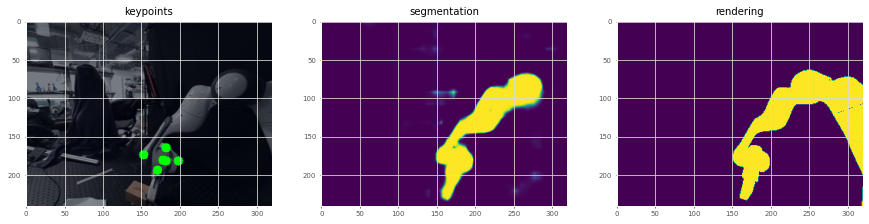

In [45]:
img_np = to_numpy_img(img)
img_np = 0.0* np.ones(img_np.shape) + img_np * 0.6
img_np = overwrite_image(img_np,points_2d.detach().cpu().numpy().squeeze().astype(int), color=(0,1,0), point_size = 6)


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("keypoints")
plt.imshow(img_np)
plt.subplot(1,3,2)
plt.title("segmentation")
plt.imshow(segmentation.squeeze().detach().cpu().numpy())
plt.subplot(1,3,3)
plt.title("rendering")
plt.imshow(rendered_image.squeeze().detach().cpu().numpy())
plt.show()